In [1]:
import pandas as pd
import numpy as np
import re

checks = pd.read_json('src/checks.json')
drops = pd.read_json('src/drops.json')
events = pd.read_json('src/events.json')
items = pd.read_json('src/items.json')
tiles = pd.read_json('src/tiles.json')
dungeons = ['Hyrule Castle', 'Eastern Palace', 'Desert Palace', 'Tower of Hera',
    'Castle Tower', 'Palace of Darkness', 'Swamp Palace', 'Skull Woods',
    'Thieves Town', 'Ice Palace', 'Misery Mire', 'Turtle Rock',
    'Ganon\'s Tower', 'Ganon']
nondungeons = ['West Hyrule', 'East Hyrule', 'South Hyrule', 'Central Hyrule',
    'Death Mountain', 'West Dark World', 'East Dark World', 'South Dark World',
    'Central Dark World', 'Dark Death Mountain']

def logparse(input_file):
    df = pd.read_csv(input_file)

    game = []
    for index, row in df.iterrows():
        step = {
            'running_time': np.nan,
            'segment_time': np.nan,
            'region': np.nan,
            'tile': np.nan,
            'indoors': np.nan,
            'check': np.nan,
            'item': np.nan,
            'event': np.nan,
        }
        
        # Time
        timestamp = row['timestamp']
        if index == 0:
            start_time = timestamp
            previous_time = start_time
        else:
            previous_time = df['timestamp'][index-1]
        step['running_time'] = timestamp - start_time
        step['segment_time'] = timestamp - previous_time

        # Tiles
        tile_id = row['tile_id']
        if not pd.isna(tile_id):
            tile = tiles[tiles['id'] == tile_id]
            step['tile'] = tile['name'].iat[0,]
            step['region'] = tile['region'].iat[0,]
            step['indoors'] = tile['indoors'].iat[0,]

        # Location
        location_id = row['location_id']
        if not pd.isna(location_id):
            step['check'] = checks[checks['id'] == location_id]['name'].iat[0,]

        # Item
        item_id = row['item_id']
        if not pd.isna(item_id):
            step['item'] = items[items['id'] == item_id]['name'].iat[0,]

        # Event
        event_id = row['event_id']
        if not pd.isna(event_id):
            event = events[events['id'] == event_id]['name'].iat[0,]
            event = re.sub(' - \d{0,9}\d\Z', '', event) # Remove the trailing counts for now
            step['event'] = event
            if event == 'Save & Quit':
                step['tile'] = 'None'
                step['region'] = 'File Select'
                step['indoors'] = np.nan
            else:
                step['tile'] = game[-1]['tile']
                step['region'] = game[-1]['region']
                step['indoors'] = game[-1]['indoors']


        if index > 0 and pd.isna(step['tile']) and pd.isna(event_id):
            step['tile'] = game[-1]['tile']
            step['region'] = game[-1]['region']
            step['indoors'] = game[-1]['indoors']

        game.append(step)

    return(pd.DataFrame(game))

def summarise(regions,game):
    s = {}
    for region in regions:
        s[region] = {'time': 0, 'visits': 0, 'checks': 0}

    route = False
    for _,event in game.iterrows():
        current_region = event['region']
        if route and current_region != region:
            route = False
            segment_time = event['running_time'] - start_time
            s[region]['time'] += segment_time
            s[region]['visits'] += 1
        if route and not pd.isna(event['check']):
            s[region]['checks'] += 1
        if not route and current_region in s:
            route = True
            start_time = event['running_time']
            region = current_region
    if route:
        route = False
        segment_time = event['running_time'] - start_time
        s[region]['time'] += segment_time
        s[region]['visits'] += 1

    # Convert to lists of dicts for pandas
    segments = []
    for region,vars in s.items():
        segment = {'region': region, 'total.secs': vars['time']/1000, 'total.mins': round(vars['time']/1000/60,2), 'visits': vars['visits'], 'checks': vars['checks']}
        segments.append(segment)

    summary = pd.DataFrame(segments)
    #sdf['total.time'] = pd.to_timedelta(sdf['Total time'], unit = 'ms')
    summary['checks.rate'] = round(summary['checks']/(summary['total.secs']/3600),1)
    return summary

def bossfights(game):
    boss_data = tiles.loc[tiles['id'].isin([240, 264, 276, 318, 351, 372, 394, 430, 457, 492])]
    bosstiles = boss_data.name.values
    b = []
    fight = False
    for i,row in game.iterrows():
        tile = row['tile']
        if tile in bosstiles:
            if not fight and pd.isna(row['check']) and pd.isna(row['item']) and pd.isna(row['event']):
                fight = True
                start_time = row['running_time']
                dungeon = row['region']
            elif fight and not pd.isna(row['check']):
                fight = False
                bosstime = round((row['running_time'] - start_time)/1000,1)
                b.append({'region': dungeon, 'boss.time': bosstime})
            if fight and row['region'] != dungeon:
                fight = False
        elif fight:
            fight = False

    return pd.DataFrame(b)


In [2]:
datadir = './RUNS/'
input_file = 'Invrosia - TwoC - 20211212_174016.csv'
game = logparse(datadir + input_file)
out_name = '{}processed_{}'.format(datadir,input_file)
#game.to_csv(out_name)

In [3]:
s = summarise(dungeons,game)
b = bossfights(game)
m = pd.merge(left=s, right=b, how='left', left_on='region', right_on='region')
m

,region,total.secs,total.mins,visits,checks,checks.rate,boss.time
0,Hyrule Castle,210.550,3.51,2,7,119.7,NaN
1,Eastern Palace,265.514,4.43,2,6,81.4,8.3
2,Desert Palace,214.214,3.57,3,6,100.8,11.4
3,Tower of Hera,101.700,1.70,1,5,177.0,15.1
4,Castle Tower,192.641,3.21,1,2,37.4,NaN
5,Palace of Darkness,452.622,7.54,3,13,103.4,26.5
6,Swamp Palace,216.010,3.60,2,8,133.3,25.4
7,Skull Woods,169.548,2.83,5,7,148.6,18.9
8,Thieves Town,264.454,4.41,2,7,95.3,29.7
9,Ice Palace,430.672,7.18,2,8,66.9,14.1


In [4]:
summarise(nondungeons,game)

,region,total.secs,total.mins,visits,checks,checks.rate
0,West Hyrule,600.454,10.01,15,20,119.9
1,East Hyrule,268.368,4.47,13,7,93.9
2,South Hyrule,528.163,8.80,17,10,68.2
3,Central Hyrule,161.933,2.70,8,2,44.5
4,Death Mountain,418.903,6.98,9,12,103.1
5,West Dark World,501.082,8.35,20,5,35.9
6,East Dark World,162.432,2.71,8,0,0.0
7,South Dark World,246.208,4.10,21,7,102.4
8,Central Dark World,29.354,0.49,2,0,0.0
9,Dark Death Mountain,348.455,5.81,12,7,72.3


In [5]:
# Evaluate checks
game_checks = game[pd.isna(game['check']) == 0][['running_time','check']]
# Checks per second 
checked = 0
check_times = []
check_avgs = []
avg = 0
for index, row in game_checks.iterrows():
    checked += 1
    time = row['running_time']/1000/3600
    avg = checked/time
    check_avgs.append(avg)
    check_times.append(time)

try:
    total_time = game[game['tile'] == 'Triforce Room']['running_time'].iat[0,]/1000/3600
except:
    total_time = game['running_time'].max()/1000/3600

check_times.append(total_time)
check_avgs.append(checked/check_times[-1])

boss_kills = sum(pd.isna(m['boss.time']) == False)

# Evaluate items
game_items = game[pd.isna(game['item']) == 0][['running_time','item']]

In [6]:
things = ['Moon Pearl', 'Boots', 'Hammer', 'Magic Mirror', 'Hookshot', 'Flute (Inactive)']

t_locs = []
for t in things:
    r = game_items[game_items['item'] == t]
    t_locs.append({'item': t, 'time': r['running_time']})


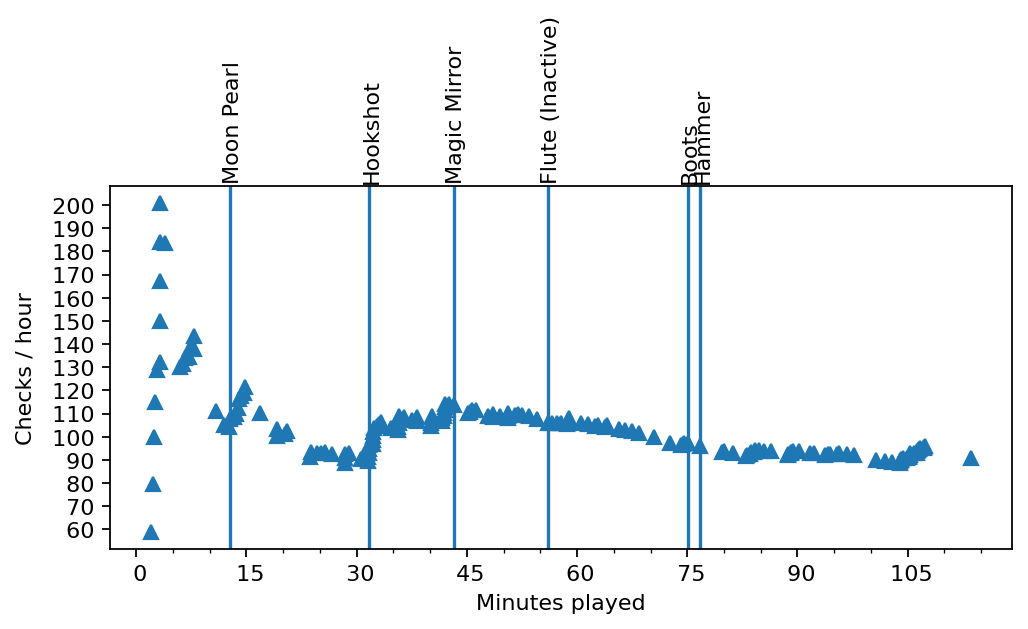

In [7]:
from matplotlib import pyplot
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

fig = pyplot.figure(figsize=(16,3), dpi = 160)
ax = fig.add_subplot(121)
#fig, ax = pyplot.subplots()
#ax.set_title('Check Rate')
ax.set_xlabel('Minutes played')
ax.set_ylabel('Checks / hour')
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.plot([x*60 for x in check_times[1:]], check_avgs[1:], '^')

for t in t_locs:
    if len(t['time']) > 0:
        time = t['time'].iat[0,]/1000/60
        pyplot.axvline(x=time)
        pyplot.text(time-1,max(check_avgs[1:])*1.05,t['item'],rotation=90)

pyplot.show()
fig_file = '{}{}.png'.format(datadir,input_file)
fig.savefig(fig_file, bbox_inches = 'tight', pad_inches = 0.3, facecolor = 'white', transparent = False)
